In [1]:
import pandas as pd
import os
import numpy as np
from shapely.geometry import Polygon
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from h3 import h3
import folium
from branca.colormap import linear, LinearColormap
from geojson import Feature, Point, FeatureCollection, Polygon
import plotly.express as px

In [3]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [5]:
#os.chdir("Schneider")

In [6]:
!pwd
#!cd ..

/Users/annepehse/Desktop/Schneider


In [54]:
data = pd.read_csv("train.csv")
data

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png
...,...,...,...,...,...
1709,0,3.819464,117.636112,2016,train_test_data/train/550.png
1710,0,-1.809594,111.531951,2005,train_test_data/train/2264.png
1711,1,0.443397,112.200163,2012,train_test_data/train/1486.png
1712,2,-1.978349,101.970148,2012,train_test_data/train/1170.png


In [8]:
data2 = data.iloc[:,:4].copy()

In [9]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714 entries, 0 to 1713
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   label      1714 non-null   int64  
 1   latitude   1714 non-null   float64
 2   longitude  1714 non-null   float64
 3   year       1714 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 53.7 KB


## EDA

In [10]:
for column, data in data2.iteritems():
    print(data.value_counts())

0    860
2    658
1    196
Name: label, dtype: int64
-2.051853    1
-3.612049    1
-2.383134    1
-1.492414    1
 1.945733    1
            ..
 1.987288    1
 0.697724    1
 1.620516    1
 1.135519    1
 0.780981    1
Name: latitude, Length: 1714, dtype: int64
111.826093    1
102.953355    1
111.520616    1
116.178544    1
98.533158     1
             ..
100.450428    1
101.280469    1
101.733958    1
101.069935    1
123.368557    1
Name: longitude, Length: 1714, dtype: int64
2015    152
2016    151
2012    145
2010    132
2009    125
2008    124
2011    124
2007    121
2013    120
2014    101
2006     98
2005     95
2004     85
2002     55
2003     45
2001     41
Name: year, dtype: int64


In [11]:
data2[data2.longitude==data2['longitude'].min()]
data2[data2.longitude==data2['longitude'].max()]

,label,latitude,longitude,year
911,2,4.380248,95.902427,2008


,label,latitude,longitude,year
798,0,-2.870846,140.900849,2011


In [12]:
round(data2['latitude']).value_counts().sort_index()

-8.0     11
-7.0     13
-6.0      6
-5.0     22
-4.0     52
-3.0    136
-2.0    308
-1.0    296
-0.0    250
 1.0    334
 2.0    172
 3.0     53
 4.0     54
 5.0      7
Name: latitude, dtype: int64

In [13]:
round(data2['longitude']).value_counts().sort_index()

96.0       8
97.0      14
98.0      38
99.0      54
100.0     67
101.0    221
102.0    263
103.0    147
104.0     62
105.0     11
106.0     10
107.0      1
108.0      8
109.0     43
110.0     97
111.0     74
112.0     78
113.0     44
114.0     53
115.0     42
116.0     50
117.0     53
118.0     35
119.0     20
120.0     19
121.0     46
122.0     55
123.0     15
124.0     10
125.0      1
126.0      2
127.0      3
128.0     13
129.0      3
130.0      1
131.0      3
132.0      7
133.0      1
134.0      4
135.0      3
136.0      2
137.0      5
138.0      1
139.0      3
140.0     13
141.0     11
Name: longitude, dtype: int64

In [14]:
round(data2['latitude']).value_counts().sort_index()

-8.0     11
-7.0     13
-6.0      6
-5.0     22
-4.0     52
-3.0    136
-2.0    308
-1.0    296
-0.0    250
 1.0    334
 2.0    172
 3.0     53
 4.0     54
 5.0      7
Name: latitude, dtype: int64

## Maps

In [15]:
H3_res = 3

In [16]:
def geo_to_h3(row):
  return h3.geo_to_h3(lat=row.latitude,lng=row.longitude,resolution = H3_res)


def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['h3_cell'], True)
  return Polygon(points)


def hexagons_dataframe_to_geojson(df_hex, hex_id_field,geometry_field, value_field,file_output = None):
    list_features = []
    for i, row in df_hex.iterrows():
        feature = Feature(geometry = row[geometry_field],
                          id = row[hex_id_field],
                          properties = {"value": row[value_field]})
        list_features.append(feature)
    feat_collection = FeatureCollection(list_features)
    if file_output is not None:
        with open(file_output, "w") as f:
            json.dump(feat_collection, f)
    else :
      return feat_collection

In [26]:
data2['h3_cell'] = data2.apply(geo_to_h3,axis=1)
data3 = data2['h3_cell'].reset_index()

In [45]:
data4 = data2[['h3_cell','label']].reset_index()

In [46]:
data3_c = (data3.groupby('h3_cell')['index'].agg(list).to_frame("ids").reset_index())
# Let's count each points inside the hexagon
data3_c['count'] =(data3_c['ids'].apply(lambda ignition_ids:len(ignition_ids)))
data3_c.sort_values('count',ascending=False)

,h3_cell,ids,count
4,836521fffffffff,"[8, 45, 62, 90, 100, 113, 116, 137, 140, 186, ...",91
14,83652efffffffff,"[16, 32, 43, 44, 54, 59, 78, 92, 162, 165, 174...",90
121,838cd2fffffffff,"[4, 40, 64, 69, 122, 136, 157, 176, 178, 201, ...",78
125,838cd6fffffffff,"[6, 36, 55, 119, 130, 141, 152, 191, 199, 213,...",76
12,83652cfffffffff,"[14, 21, 70, 77, 125, 126, 160, 200, 248, 253,...",70
...,...,...,...
130,838cf2fffffffff,[1552],1
54,8368c8fffffffff,[1397],1
134,838d85fffffffff,[530],1
133,838cf6fffffffff,[769],1


In [44]:
data3_c['count'].sum()

1714

In [30]:
data4_c = (data4.groupby(['h3_cell','label'])['index'].agg(list).to_frame("ids").reset_index())
# Let's count each points inside the hexagon
data4_c['count'] =(data4_c['ids'].apply(lambda ignition_ids:len(ignition_ids)))
data4_c.sort_values('count',ascending=False)

,h3_cell,label,ids,count
7,836521fffffffff,0,"[8, 45, 100, 113, 116, 137, 140, 242, 263, 264...",69
231,838cd2fffffffff,0,"[4, 64, 69, 122, 136, 176, 249, 287, 304, 312,...",50
34,83652efffffffff,2,"[16, 44, 54, 59, 78, 92, 162, 165, 183, 212, 2...",50
245,838cd6fffffffff,2,"[55, 130, 141, 152, 191, 260, 316, 323, 441, 5...",39
243,838cd6fffffffff,0,"[36, 119, 199, 213, 327, 330, 342, 421, 427, 4...",34
...,...,...,...,...
145,83728afffffffff,2,[866],1
144,837283fffffffff,2,[1327],1
143,837282fffffffff,1,[592],1
142,837280fffffffff,0,[1380],1


In [35]:
#Apply function into our dataframe
data3_c['geometry'] = (data4_c.apply(add_geometry,axis=1))
data4_c['geometry'] = (data4_c.apply(add_geometry,axis=1))

In [36]:
geojson_obj = (hexagons_dataframe_to_geojson(data3_c,hex_id_field='h3_cell',value_field='count',geometry_field='geometry'))
geojson_obj2 = (hexagons_dataframe_to_geojson(data4_c,hex_id_field='h3_cell',value_field='count',geometry_field='geometry'))

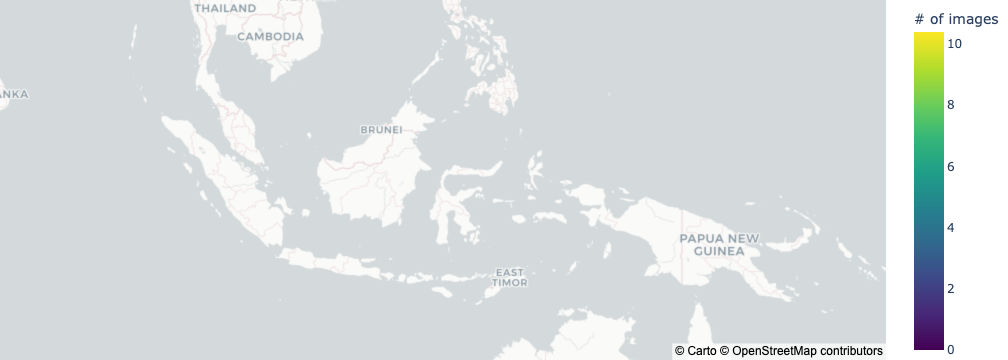

In [47]:
fig = (px.choropleth_mapbox(
                    data3_c, 
                    geojson=geojson_obj, 
                    locations='h3_cell', 
                    color='count',
                    color_continuous_scale="Viridis",
                    range_color=(0,data3_c['count'].mean()), mapbox_style='carto-positron',
                    zoom=3,
                    center = {"lat": 0, "lon": 120},
                    opacity=0.7,
                    labels={'count':'# of images'}))
_ = fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

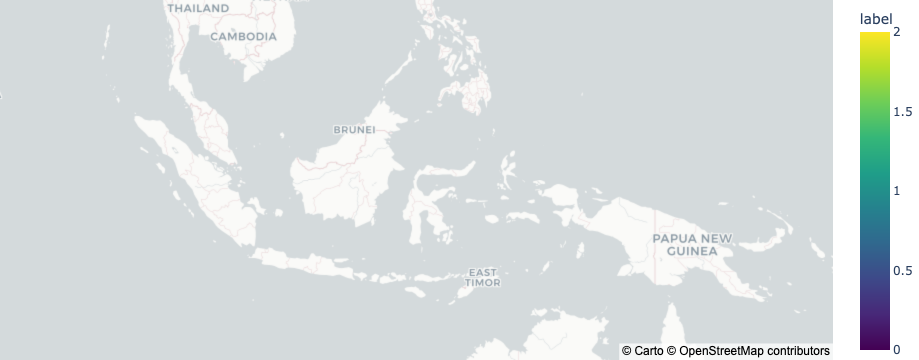

In [38]:
fig = (px.choropleth_mapbox(
                    data4_c, 
                    geojson=geojson_obj, 
                    locations='h3_cell', 
                    color='label',
                    color_continuous_scale="Viridis",
                    #range_color=(0,data4_c['count'].mean()), 
                    mapbox_style='carto-positron',
                    zoom=3,
                    center = {"lat": 0, "lon": 120},
                    opacity=0.7,# of images
                    labels={'count':''}
))
_ = fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

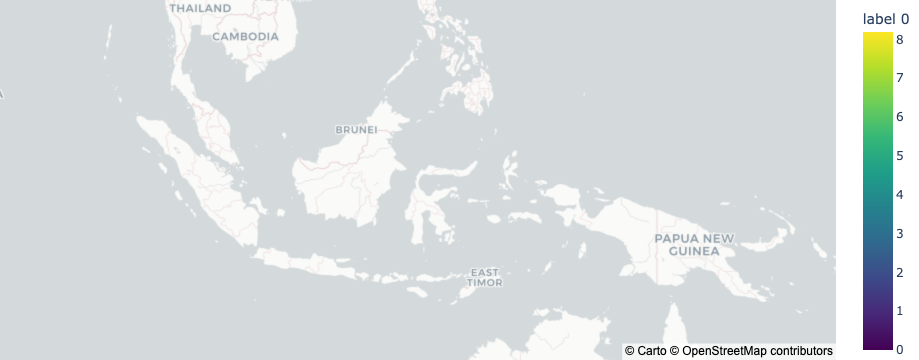

In [39]:
fig = (px.choropleth_mapbox(
                    data4_c[data4_c['label']==0], 
                    geojson=geojson_obj, 
                    locations='h3_cell', 
                    color='count',
                    color_continuous_scale="Viridis",
                    range_color=(0,data4_c[data4_c['label']==0]['count'].mean()), mapbox_style='carto-positron',
                    zoom=3,
                    center = {"lat": 0, "lon": 120},
                    opacity=0.7,
                    labels={'count':'label 0'}))
_ = fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

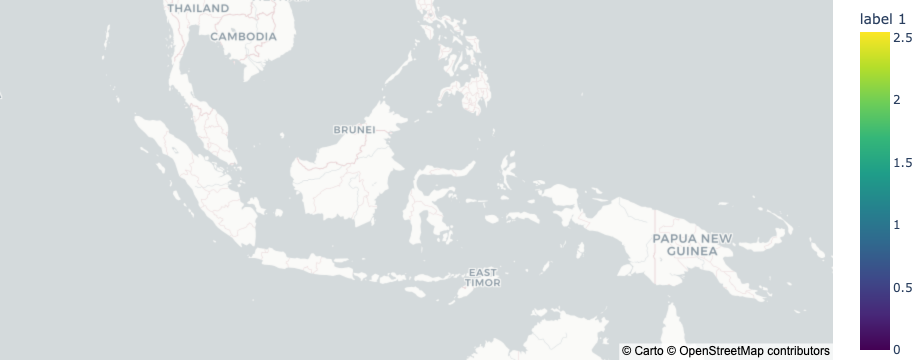

In [40]:
fig = (px.choropleth_mapbox(
                    data4_c[data4_c['label']==1], 
                    geojson=geojson_obj, 
                    locations='h3_cell', 
                    color='count',
                    color_continuous_scale="Viridis",
                    range_color=(0,data4_c[data4_c['label']==1]['count'].mean()), mapbox_style='carto-positron',
                    zoom=3,
                    center = {"lat": 0, "lon": 120},
                    opacity=0.7,
                    labels={'count':'label 1'}))
_ = fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

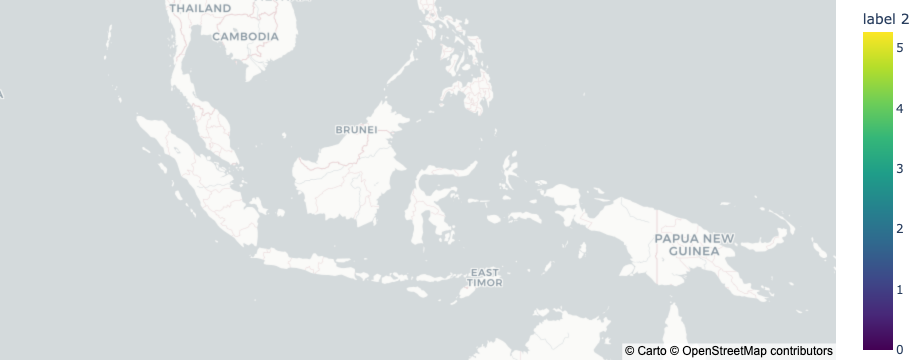

In [41]:
fig = (px.choropleth_mapbox(
                    data4_c[data4_c['label']==2], 
                    geojson=geojson_obj, 
                    locations='h3_cell', 
                    color='count',
                    color_continuous_scale="Viridis",
                    range_color=(0,data4_c[data4_c['label']==2]['count'].mean()), mapbox_style='carto-positron',
                    zoom=3,
                    center = {"lat": 0, "lon": 120},
                    opacity=0.7,
                    labels={'count':'label 2'}))
_ = fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Lightgbm

In [60]:
split = pd.read_csv("deforestation/split_data/train_folds.csv")
data_split = pd.merge(data, split, on="example_path")
data_split

,label,latitude,longitude,year,example_path,fold
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png,4
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png,0
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png,3
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png,0
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png,1
...,...,...,...,...,...,...
1709,0,3.819464,117.636112,2016,train_test_data/train/550.png,2
1710,0,-1.809594,111.531951,2005,train_test_data/train/2264.png,0
1711,1,0.443397,112.200163,2012,train_test_data/train/1486.png,3
1712,2,-1.978349,101.970148,2012,train_test_data/train/1170.png,1


In [61]:
test = data_split[data_split.fold==0]
train = data_split[data_split.fold!=0]
#fold 0 to validate
train.shape
test.shape

(1371, 6)

(343, 6)

In [62]:
x_train, y_train = train[['latitude','longitude','year']].copy(), train.label.copy()
x_test, y_test = test[['latitude','longitude','year']].copy(), test.label.copy()

In [63]:
model = lgb.LGBMClassifier()
model.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [64]:
expected_y  = y_test
predicted_y = model.predict(x_test)

In [65]:
f1_score(expected_y, predicted_y, average='macro')

0.6399989196780641

In [74]:
probas = model.predict_proba(x_test)
lightgbm = pd.DataFrame(probas, columns = ['0','1','2'])

## IMPORT DAVID'S SCORES

In [97]:
train_s = pd.read_csv("train_scores.csv")
val_s = pd.read_csv("validation_scores.csv")
# train2["short_path"] = train2["example_path"].apply(lambda x: x.split("/")[-1])
# test2["short_path"] = test2["example_path"].apply(lambda x: x.split("/")[-1])
# train2_d = pd.merge(train2, train_s, on="short_path")
# test2_d = pd.merge(test2, val_s, on="short_path")
val_s.head()

,short_path,0,1,2
0,1088.png,0.999525,0.000387,0.000089
1,1684.png,0.936209,0.040661,0.023130
2,491.png,0.043629,0.869043,0.087328
3,718.png,0.996999,0.000891,0.002110
4,2176.png,0.027057,0.006478,0.966465


In [112]:
x_2 = test.copy()
x_2["short_path"] = x_2["example_path"].apply(lambda x: x.split("/")[-1])

In [114]:
lightgbm_p = pd.concat([lightgbm,x_2[['short_path']].reset_index(drop=True)], axis=1)
lightgbm_p.sort_values('short_path')#head()

,0,1,2,short_path
230,0.299986,0.555933,0.144080,0.png
18,0.972534,0.000052,0.027413,1003.png
195,0.042482,0.215225,0.742293,1027.png
13,0.894244,0.050044,0.055711,1029.png
217,0.153236,0.000110,0.846654,1031.png
...,...,...,...,...
161,0.980217,0.000106,0.019677,980.png
218,0.018360,0.371916,0.609724,981.png
32,0.937975,0.045231,0.016794,982.png
167,0.364890,0.000726,0.634383,996.png


In [116]:
both = pd.merge(lightgbm_p, val_s, on="short_path")
both['0'] = (both['0_x']+both['0_y'])/2
both['1'] = (both['1_x']+both['1_y'])/2
both['2'] = (both['2_x']+both['2_y'])/2
result = both[['0','1','2']].copy()
result['class'] = result.eq(result.max(1), axis=0).dot(result.columns).astype(int)
result

,0,1,2,class
0,0.213055,0.151603,0.635342,2
1,0.800329,0.001636,0.198036,0
2,0.114882,0.437495,0.447622,2
3,0.591336,0.151370,0.257294,0
4,0.002430,0.004453,0.993117,2
...,...,...,...,...
338,0.979441,0.004238,0.016320,0
339,0.976036,0.006496,0.017468,0
340,0.660734,0.000685,0.338581,0
341,0.976125,0.001425,0.022450,0


In [120]:
f1_score(expected_y, result['class'], average='macro')

0.7502060190849033

In [58]:
data_split2 = data_split.copy()

In [527]:
test2 = data_split2[data_split2.fold==0].copy()
train2 = data_split2[data_split2.fold!=0].copy()
#fold 0 to validate
train2.shape
test2.shape

(1371, 6)

(343, 6)

In [534]:
train2_d.shape
test2_d.shape
test2_d.columns

(1371, 10)

(343, 10)

Index(['label', 'latitude', 'longitude', 'year', 'example_path', 'fold',
       'short_path', '0', '1', '2'],
      dtype='object')

In [535]:
x_train2, y_train2 = train2_d[['latitude','longitude','year','0','1','2']].copy(), train2.label.copy()
x_test2, y_test2 = test2_d[['latitude','longitude','year','0','1','2']].copy(), test2.label.copy()

In [453]:
#comp = pd.concat([expected_y.reset_index(drop=True), pd.DataFrame(predicted_y, columns=["pred"])], axis=1)

In [454]:
# comp0= comp.copy()
# comp1= comp.copy()
# comp2= comp.copy()
# comp0['pred'] = np.where(comp0.pred!=0, 5, 1)
# comp0['pred'] = np.where(comp0.pred==5, 0, comp0['pred'])
# comp0['label'] = np.where(comp0.label!=0, 5, 1)
# comp0['label'] = np.where(comp0.label==5, 0, comp0['label'])

# comp1['pred'] = np.where(comp1.pred!=1, 0, comp1['pred'])
# comp1['label'] = np.where(comp1.label!=1, 0, comp1['label'])

# comp2['pred'] = np.where(comp2.pred!=2, 0, 1)
# comp2['label'] = np.where(comp2.label!=2, 0, 1)

In [66]:
# f1_score(comp0.label, comp0.pred)
# f1_score(comp1.label, comp1.pred)
# f1_score(comp2.label, comp2.pred)

In [536]:
model2 = lgb.LGBMClassifier()
model2.fit(x_train2,y_train2)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [537]:
expected_y2  = y_test2
predicted_y2 = model2.predict(x_test2)

In [538]:
predicted_y2

array([2, 0, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2, 1, 2, 2, 0, 0, 2, 0,
       0, 1, 0, 1, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 2,
       0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 1,
       2, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2,
       2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0,
       0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 1, 0, 1, 2, 0, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 2, 0, 1, 0, 2,
       0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 1, 1,
       0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 2, 0, 0, 2,
       2, 1, 2, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 1, 0, 2, 2, 2, 1, 0, 1, 2,
       1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0,

In [539]:
f1_score(expected_y2, predicted_y2, average='macro')

0.7401498757950115

In [68]:
#comp = pd.concat([expected_y2.reset_index(drop=True), pd.DataFrame(predicted_y2, columns=["pred"])], axis=1)

In [69]:
# comp0= comp.copy()
# comp1= comp.copy()
# comp2= comp.copy()
# comp0['pred'] = np.where(comp0.pred!=0, 5, 1)
# comp0['pred'] = np.where(comp0.pred==5, 0, comp0['pred'])
# comp0['label'] = np.where(comp0.label!=0, 5, 1)
# comp0['label'] = np.where(comp0.label==5, 0, comp0['label'])

# comp1['pred'] = np.where(comp1.pred!=1, 0, comp1['pred'])
# comp1['label'] = np.where(comp1.label!=1, 0, comp1['label'])

# comp2['pred'] = np.where(comp2.pred!=2, 0, 1)
# comp2['label'] = np.where(comp2.label!=2, 0, 1)

In [70]:
# f1_score(comp0.label, comp0.pred)
# f1_score(comp1.label, comp1.pred)
# f1_score(comp2.label, comp2.pred)

In [560]:
x_test = test.copy()

In [575]:
lightgbm.head()

,0,1,2
0,0.154792,0.583334,0.261874
1,0.613880,0.000854,0.385266
2,0.248427,0.172381,0.579192
3,0.132446,0.328843,0.538711
4,0.003049,0.000118,0.996833


In [574]:
lightgbm = pd.DataFrame(probas, columns = ['0','1','2'])
x_test["short_path"] = x_test["example_path"].apply(lambda x: x.split("/")[-1])
lightgbm_p = pd.concat([lightgbm,x_test[['short_path']].reset_index(drop=True)], axis=1)

,0,1,2,class
0,0.078254,0.297364,0.624382,2
1,0.805620,0.001727,0.192653,0
2,0.124266,0.502934,0.372800,1
3,0.565336,0.164691,0.269974,0
4,0.001747,0.004470,0.993783,2
...,...,...,...,...
338,0.992158,0.004207,0.003634,0
339,0.966147,0.006560,0.027292,0
340,0.625681,0.000756,0.373563,0
341,0.957884,0.001346,0.040770,0


In [596]:
type(result.iloc[0,0])

numpy.float64

In [597]:
f1_score(expected_y2, result['class'], average='macro')

0.758575131613361

In [485]:
# from PIL import Image

In [487]:
# X = []

# for i, row in data.iterrows():
#   print(i)
#   im = Image.open(row.example_path).resize((224,224))
#   image_array = np.asarray(im)
#   X.append(image_array)

# X = np.array(X)

# np.save("pics/X_224.npy", X)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

FileNotFoundError: [Errno 2] No such file or directory: 'pics/X_224.npy'

In [517]:
# means = []
# for n in X:
#     means.append(n.mean())

In [518]:
# means[:4]

In [519]:
# data_split2 = data_split.copy()
# data_split2['pics'] = means
# data_split2